In [7]:
!pip install einops

In [14]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import torch
from google.colab import drive
from einops import rearrange
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
class RotaryPositionalEmbeddings(tf.keras.layers.Layer):
    def __init__(self, dim, max_seq_len):
        super(RotaryPositionalEmbeddings, self).__init__()
        self.dim = dim
        self.max_seq_len = max_seq_len

        # Precompute the rotation matrices
        inv_freq = 1.0 / (10000 ** (tf.range(0, dim, 2, dtype=tf.float32) / dim))
        t = tf.range(max_seq_len, dtype=tf.float32)
        freqs = tf.einsum('i,j->ij', t, inv_freq)  # shape: (max_seq_len, dim // 2)
        self.cos = tf.cos(freqs)  # shape: (max_seq_len, dim // 2)
        self.sin = tf.sin(freqs)  # shape: (max_seq_len, dim // 2)

    def call(self, q, k):
        # Reshape rotation matrices to match q and k
        cos = rearrange(self.cos, 'n d -> 1 n 1 d') # shape: (1, max_seq_len, 1, dim // 2)
        sin = rearrange(self.sin, 'n d -> 1 n 1 d') # shape: (1, max_seq_len, 1, dim // 2)

        # Apply rotary embeddings
        q1, q2 = tf.split(q, 2, axis=-1)
        k1, k2 = tf.split(k, 2, axis=-1)

        # Use broadcasting for element-wise multiplication
        q_rotated = tf.concat([q1 * cos - q2 * sin, q1 * sin + q2 * cos], axis=-1)
        k_rotated = tf.concat([k1 * cos - k2 * sin, k1 * sin + k2 * cos], axis=-1)

        return q_rotated, k_rotated

In [16]:
# Rotary Positional Embeddings
class RopeAttention(tf.keras.layers.Layer):
    def __init__(self, embedding_dim, num_heads, max_seq_len, dropout_rate):
        super(RopeAttention, self).__init__()
        self.num_heads = num_heads
        self.embedding_dim = embedding_dim
        self.head_dim = embedding_dim // num_heads

        # Rotary positional embeddings
        self.rope_layer = RotaryPositionalEmbeddings(self.head_dim, max_seq_len)

        # Attention layers
        self.q_proj = tf.keras.layers.Dense(embedding_dim)
        self.k_proj = tf.keras.layers.Dense(embedding_dim)
        self.v_proj = tf.keras.layers.Dense(embedding_dim)
        self.output_proj = tf.keras.layers.Dense(embedding_dim)
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x, mask=None):
        # Get the shape of x using tf.shape outside the graph construction
        batch_size = tf.shape(x)[0]
        seq_len = tf.shape(x)[1]

        # Compute Q, K, V
        q = self.q_proj(x)
        k = self.k_proj(x)
        v = self.v_proj(x)

        # Split heads
        q = tf.reshape(q, (batch_size, seq_len, self.num_heads, self.head_dim))
        k = tf.reshape(k, (batch_size, seq_len, self.num_heads, self.head_dim))
        v = tf.reshape(v, (batch_size, seq_len, self.num_heads, self.head_dim))

        # Apply rotary embeddings
        q, k = self.rope_layer(q, k)

        # Scaled dot-product attention
        attn_scores = tf.einsum('bnhd,bmhd->bhnm', q, k) / tf.math.sqrt(tf.cast(self.head_dim, tf.float32))

        if mask is not None:
            attn_scores += (mask * -1e9)

        attn_probs = tf.nn.softmax(attn_scores, axis=-1)
        attn_probs = self.dropout(attn_probs)

        # Compute attention output
        attn_output = tf.einsum('bhnm,bmhd->bnhd', attn_probs, v)
        attn_output = tf.reshape(attn_output, (batch_size, seq_len, self.embedding_dim))

        return self.output_proj(attn_output)


In [17]:
# Load preprocessed tensors and create loaders

def create_loaders_from_pt(batch_size=16):
    # Load the PyTorch .pt files
    train_images = torch.load('/content/drive/MyDrive/image_net_10/train_images.pt').numpy()
    train_labels = torch.load('/content/drive/MyDrive/image_net_10/train_labels.pt').numpy()

    val_images = torch.load('/content/drive/MyDrive/image_net_10/val_images.pt').numpy()
    val_labels = torch.load('/content/drive/MyDrive/image_net_10/val_labels.pt').numpy()

    test_images = torch.load('/content/drive/MyDrive/image_net_10/test_images.pt').numpy()
    test_labels = torch.load('/content/drive/MyDrive/image_net_10/test_labels.pt').numpy()

    # Create TensorFlow datasets
    def preprocess(image, label):
        image = tf.image.resize(image, (224, 224))
        image = tf.cast(image, tf.float32) / 255.0
        return image, label

    train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
    train_dataset = train_dataset.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
    val_dataset = val_dataset.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
    test_dataset = test_dataset.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return train_dataset, val_dataset, test_dataset

train_dataset, val_dataset, test_dataset = create_loaders_from_pt()


<ipython-input-17-6252482d40cf>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_images = torch.load('/content/drive/MyDrive/image_net_10/train_images.pt').numpy()
<ip

In [18]:
# Define the Vision Transformer
class VisionTransformer(tf.keras.Model):
    def __init__(self, image_size, patch_size, num_classes, embedding_dim, num_heads, num_layers, max_seq_len, dropout_rate):
        super(VisionTransformer, self).__init__()
        self.patch_size = patch_size
        self.num_patches = (image_size // patch_size) ** 2
        self.embedding_dim = embedding_dim

        # Patch embedding layer
        self.patch_embedding = tf.keras.layers.Conv2D(embedding_dim, patch_size, strides=patch_size, padding='valid')

        # Positional embeddings
        self.pos_embedding = tf.Variable(tf.random.normal([1, self.num_patches, embedding_dim]), trainable=True)

        # Transformer layers
        self.transformer_layers = [
            RopeAttention(embedding_dim, num_heads, max_seq_len, dropout_rate)
            for _ in range(num_layers)
        ]

        # Classification head
        self.cls_head = tf.keras.Sequential([
            tf.keras.layers.GlobalAveragePooling1D(),
            tf.keras.layers.Dropout(dropout_rate),
            tf.keras.layers.Dense(num_classes, activation='softmax')
        ])

    def call(self, inputs):
        # Extract patches and embed
        patches = self.patch_embedding(inputs)
        patches = tf.reshape(patches, [-1, self.num_patches, self.embedding_dim])

        # Add positional embeddings
        patches += self.pos_embedding

        # Apply transformer layers
        x = patches
        for layer in self.transformer_layers:
            x = layer(x)

        # Classification head
        return self.cls_head(x)

In [19]:
# Initialize and compile the model
model = VisionTransformer(
    image_size=224,
    patch_size=16,
    num_classes=10,
    embedding_dim=64,
    num_heads=8,
    num_layers=6,
    max_seq_len=196,
    dropout_rate=0.1
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

# Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[early_stopping]
)

Epoch 1/20
586/586 ━━━━━━━━━━━━━━━━━━━━ 106s 128ms/step - accuracy: 0.1728 - loss: 2.2303 - val_accuracy: 0.2135 - val_loss: 2.1813
Epoch 2/20
586/586 ━━━━━━━━━━━━━━━━━━━━ 51s 87ms/step - accuracy: 0.2357 - loss: 2.1256 - val_accuracy: 0.2867 - val_loss: 2.0142
Epoch 3/20
586/586 ━━━━━━━━━━━━━━━━━━━━ 51s 86ms/step - accuracy: 0.3143 - loss: 1.9505 - val_accuracy: 0.3245 - val_loss: 1.9501
Epoch 4/20
586/586 ━━━━━━━━━━━━━━━━━━━━ 51s 87ms/step - accuracy: 0.3457 - loss: 1.8731 - val_accuracy: 0.3330 - val_loss: 1.9175
Epoch 5/20
586/586 ━━━━━━━━━━━━━━━━━━━━ 51s 87ms/step - accuracy: 0.3702 - loss: 1.8172 - val_accuracy: 0.3375 - val_loss: 1.8859
Epoch 6/20
586/586 ━━━━━━━━━━━━━━━━━━━━ 51s 87ms/step - accuracy: 0.3873 - loss: 1.7684 - val_accuracy: 0.3534 - val_loss: 1.8520
Epoch 7/20
586/586 ━━━━━━━━━━━━━━━━━━━━ 51s 86ms/step - accuracy: 0.4016 - loss: 1.7240 - val_accuracy: 0.3688 - val_loss: 1.8201
Epoch 8/20
586/586 ━━━━━━━━━━━━━━━━━━━━ 51s 87ms/step - accuracy: 0.4189 - loss: 1.6839 

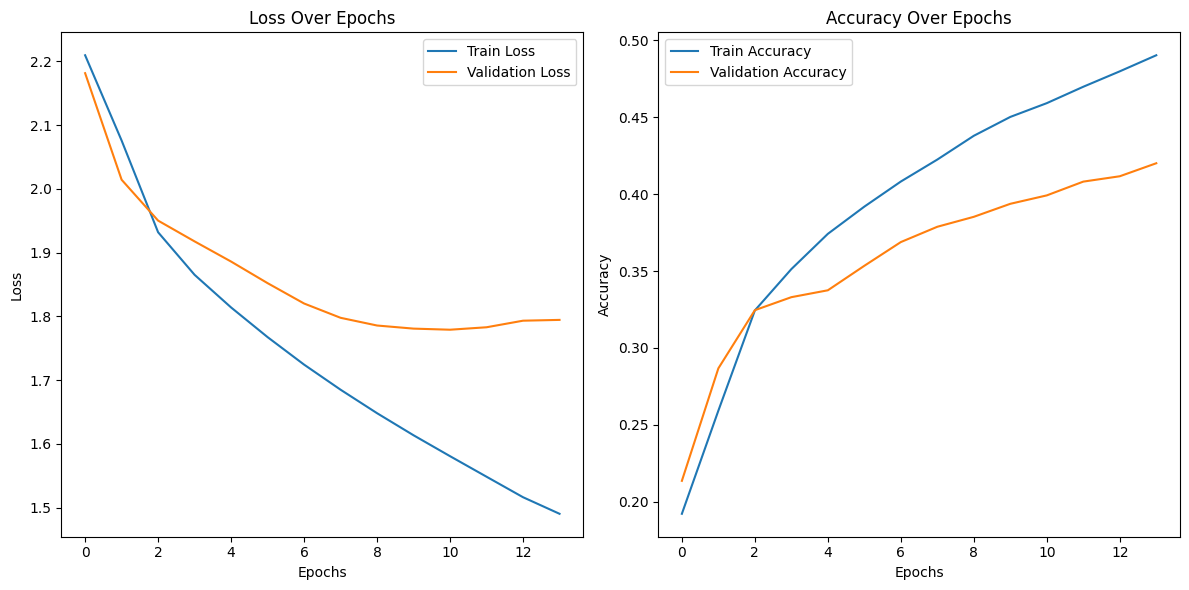

Inference Time per Batch: 1.2536 seconds
126/126 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.3868 - loss: 1.7868
Validation Loss: 1.7790, Validation Accuracy: 0.3992


In [20]:
# Plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

# Measure inference time
def measure_inference_time(model, sample_batch):
    start_time = time.time()
    _ = model(sample_batch, training=False)
    end_time = time.time()
    return end_time - start_time

# Create a sample batch for inference
def create_sample_batch(dataset):
    for images, _ in dataset.take(1):
        return images

sample_batch = create_sample_batch(val_dataset)
inference_time = measure_inference_time(model, sample_batch)
print(f"Inference Time per Batch: {inference_time:.4f} seconds")

# Evaluate the model
val_loss, val_accuracy = model.evaluate(val_dataset)
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")